# Python packages

In [1]:
%matplotlib inline
import gym
import random
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
isIPython = 'inline' in matplotlib.get_backend()
if isIPython: from IPython import display

# Deep Q Network

In [3]:
class DQN(nn.Module):
    def __init__(self, imgHeight, imgWidth):
        super().__init__()
        self.fullyConnectedLayer1 = nn.Linear(in_features=imgHeight*imgWidth*3, out_features=24)
        self.fullyConnectedLayer2 = nn.Linear(in_features=24, out_features=32)
        self.outputLayer = nn.Linear(in_features=32, out_features=2)
        
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fullyConnectedLayer1(t))
        t = F.relu(self.fullyConnectedLayer2(t))
        t = F.relu(self.outputLayer(t))
        return t

# Experiences 

In [4]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'nextState','reward')
)

In [5]:
e = Experience(2,3,1,4)
e

Experience(state=2, action=3, nextState=1, reward=4)

# Replay Memory

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.pushCount = 0
        
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.pushCount % self.capacity] = experience
        self.pushCount += 1
        
    def sample(self, batch):
        return random.sample(self.memory, batchSize)
    
    def canProvideSample(self, batchSize):
        return len(self.memory) >= batchSize

# Epsilon Greedy Strategy

In [7]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def getExplorationRate(self, currentStep):
        return self.end + (self.start - self.end) * math.exp(-1. * currentStep * self.decay)

# Reinforcement Learning Agent

In [8]:
class Agent():
    def __init__(self, strategy, numActions, device):
        self.currentStep = 0
        self.strategy = strategy
        self.numActions = numActions
        self.device = device
        
    def selectAction(self, state, policyNet):
        rate = strategy.getExplorationRate(self.currentStep)
        self.currentStep += 1
        
        if rate > random.random():
            action = random.randrange(self.numActions)
            return torch.tensor([action]).to(self.device)
        else:
            with torch.no_grad():
                return policyNet(state).argmax(dim=1).to(self.device)
        

# Environment Manager

In [9]:
class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.currentScreen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
        
    def close(self):
        self.env.close
        
    def render(self, mode = 'human'):
        return self.env.render(mode)
    
    def numActionsAvailable(self):
        return self.env.action_space.n
    
    def takeAction(self, action):
        _, reward, self.done, _ = self.env.step(action.item())
        return torch.tensor([reward], device = self.device)
    
    def justStarting(self):
        return self.currentScreen is None
    
    def getState(self):
        if self.justStarting() or self.done:
            self.currentScreen = self.getProcessedScreen()
            black_screen = torch.zeros_like(self.currentScreen)
            return black_screen
        else:
            s1 = self.currentScreen
            s2 = self.getProcessedScreen()
            self.currentScreen = s2
            return s2 - s1

# Image Processing for the Neural network

    def screenHeight(self):
        screen = self.getProcessedScreen()
        return screen.shape[2]
    
    def screenWidth(self):
        screen = self.getProcessedScreen()
        return screen.shape[3]
    
    def getProcessedScreen(self):
        screen = self.render('rgb_array').transpose((2,0,1))
        screen = self.cropScreen(screen)
        return self.transformScreenData(screen)
    
    def cropScreen(self, screen):
        screenHeight = screen.shape[1]
        
        top = int(screenHeight * 0.4)
        bottom = int(screenHeight * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transformScreenData(self, screen):
        screen = np.ascontiguousarray(screen, dtype = np.float32) / 255
        screen = torch.from_numpy(screen)
        
        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])
        
        return resize(screen).unsqueeze(0).to(self.device)

# Example of Screen that is not Processed

<function matplotlib.pyplot.show(close=None, block=None)>

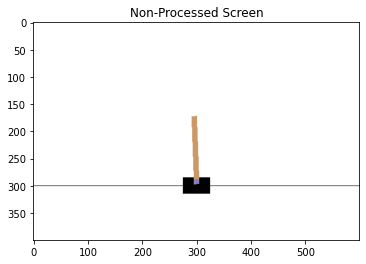

In [10]:
device = torch.device("cpu")
trY = CartPoleEnvManager(device)
trY.reset()
screen = trY.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.title("Non-Processed Screen")
plt.show

# Example of Processed Screen

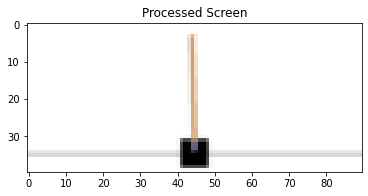

In [11]:
screen = trY.getProcessedScreen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = 'none')
plt.title("Processed Screen")
plt.show()


# Example of Starting State

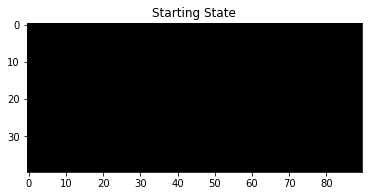

In [12]:
screen = trY.getState()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = 'none')
plt.title("Starting State")
plt.show()


# Example of Non-Starting State

/opt/anaconda3/lib/python3.8/site-packages/gym/envs/classic_control/cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


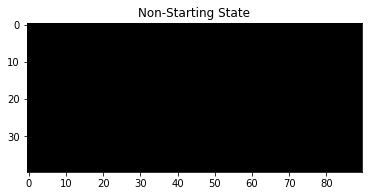

In [13]:
for i in range(10):
    trY.takeAction(torch.tensor([1]))
screen = trY.getState()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0), interpolation = 'none')
plt.title("Non-Starting State")
plt.show()

# Plotting Graphs

In [14]:
def plotIT(values, movingAveragePeriod):
    plt.figure(2)
    plt.clf()
    plt.title("...Training...")
    plt.xlabel("Episode")
    plt.ylabel("Duration")
    plt.plot(values)
    movingAverage = getMovingAverage(movingAveragePeriod, values)
    plt.plot(movingAverage) 
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
    movingAveragePeriod, "episode moving avg:", movingAverage[-1])
    if isIPython: display.clear_output(wait=True)
        
def getMovingAverage(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        movingAverage = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        movingAverage = torch.cat((torch.zeros(period-1), movingAverage))
        return movingAverage.numpy()
    else:
        movingAverage = torch.zeros(len(values))
        return movingAverage.numpy()

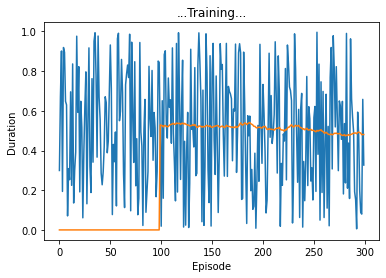

Episode 300 
 100 episode moving avg: 0.48082513


In [15]:
plotIT(np.random.rand(300), 100)

# Tensor Processing

In [16]:
def extractTensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.nextState)
    
    return (t1,t2,t3,t4)    

# Q-Value Calculator

In [17]:
class QValues():
    device = torch.device("cpu")
    
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

# MAIN PROGRAM

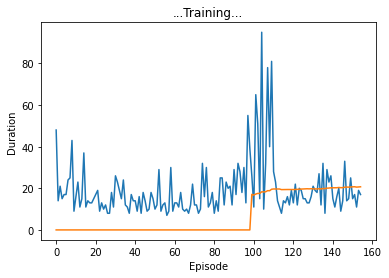

Episode 155 
 100 episode moving avg: 20.72


In [ ]:
batchSize = 256
gamma = 0.999
epsStart = 1
epsEnd = 0.01
epsDecay = 0.001
targetUpdate = 10
memorySize = 100000
learningRate = 0.001
numEpisodes = 1000

devicE = torch.device("cpu")
em = CartPoleEnvManager(devicE)
strategy = EpsilonGreedyStrategy(epsStart,epsEnd,epsDecay)
agent = Agent(strategy, em.numActionsAvailable(), devicE)
memory = ReplayMemory(memorySize)

policyNet = DQN(em.screenHeight(), em.screenWidth()).to(devicE)
targetNet = DQN(em.screenHeight(), em.screenWidth()).to(devicE)
targetNet.load_state_dict(policyNet.state_dict())
targetNet.eval()
optimizer = optim.Adam(params = policyNet.parameters(), lr=learningRate)

episodeDurations = []

for episode in range(numEpisodes):
    em.reset()
    state = em.getState()
    
    for timestep in count():
        action = agent.selectAction(state, policyNet)
        reward = em.takeAction(action)
        nextState = em.getState()
        memory.push(Experience(state, action, nextState, reward))
        state = nextState
        
        if memory.canProvideSample(batchSize):
            experiences = memory.sample(batchSize)
            states, actions, rewards, nextStates = extractTensors(experiences)
            
            currentQValues = QValues.get_current(policyNet, states, actions)
            nextQValues = QValues.get_next(targetNet, nextStates)
            targetQValues = (nextQValues * gamma) + rewards
            
            loss = F.mse_loss(currentQValues, targetQValues.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        if em.done:
            episodeDurations.append(timestep)
            plotIT(episodeDurations, 100)
            break
            
    if episode % targetUpdate == 0:
        targetNet.load_state_dict(policyNet.state_dict())
        
em.close()